<a href="https://colab.research.google.com/github/anasCSD/Glaucoma-Classification/blob/main/DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print("Pytorch version:", torch.__version__)

Pytorch version: 2.9.0+cu126


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
%pip install ipython-autotime
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.5 MB/s eta 0:00:00
time: 231 µs (started: 2025-12-11 11:20:05 +00:00)


In [ ]:
!pip install torchinfo

time: 9.48 s (started: 2025-12-11 11:20:06 +00:00)


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import os
import random
import shutil
import PIL as pil
import cv2
import matplotlib as mpl
import tqdm
from PIL import Image
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

time: 3.54 ms (started: 2025-12-11 11:22:06 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 23.7 s (started: 2025-12-11 11:20:38 +00:00)


In [ ]:
base_url = '/content/drive/MyDrive/Research'

batch_size = 4
img_height = 224
img_width = 224

class_names = ['glaucoma', 'normal']

time: 582 µs (started: 2025-12-11 11:21:04 +00:00)


In [ ]:
def model_summary(model:torch.nn.Module,
                  input_size:tuple):
  return summary(model=model,
                input_size=input_size,
                col_names=["input_size", "output_size", "num_params", "trainable"],
                col_width=20,
                row_settings=['var_names'])

time: 635 µs (started: 2025-12-11 11:21:08 +00:00)


In [ ]:
dataset_url = '/content/drive/MyDrive/Research/Glaucoma_Splitted'
train_path = f'{dataset_url}/train'
valid_path = f'{dataset_url}/val'
test_path  = f'{dataset_url}/test'

time: 979 µs (started: 2025-12-11 11:21:13 +00:00)


In [ ]:
def apply_clahe(pil_img):
    img = np.array(pil_img)

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    lab = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    return Image.fromarray(enhanced)

time: 2.39 ms (started: 2025-12-11 11:22:11 +00:00)


In [ ]:
train_transform = transforms.Compose([
    transforms.Lambda(lambda img: apply_clahe(img)),
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Lambda(lambda img: apply_clahe(img)),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ==========================================================
#   DATASET & LOADERS
# ==========================================================
train_ds = datasets.ImageFolder(root=train_path, transform=train_transform)
valid_ds = datasets.ImageFolder(root=valid_path, transform=val_test_transform)
test_ds  = datasets.ImageFolder(root=test_path,  transform=val_test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

time: 6.25 s (started: 2025-12-11 11:22:18 +00:00)


In [ ]:
num_classes = 2

model = torchvision.models.densenet121(weights='DEFAULT')

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential()

num_features = 1024

custom_classifier = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(512, num_classes)
)

model.classifier = custom_classifier

model_summary(model=model,
              input_size=(4,3,224,224))

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 158MB/s]


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [4, 3, 224, 224]     [4, 2]               --                   Partial
├─Sequential (features)                       [4, 3, 224, 224]     [4, 1024, 7, 7]      --                   False
│    └─Conv2d (conv0)                         [4, 3, 224, 224]     [4, 64, 112, 112]    (9,408)              False
│    └─BatchNorm2d (norm0)                    [4, 64, 112, 112]    [4, 64, 112, 112]    (128)                False
│    └─ReLU (relu0)                           [4, 64, 112, 112]    [4, 64, 112, 112]    --                   --
│    └─MaxPool2d (pool0)                      [4, 64, 112, 112]    [4, 64, 56, 56]      --                   --
│    └─_DenseBlock (denseblock1)              [4, 64, 56, 56]      [4, 256, 56, 56]     --                   False
│    │    └─_DenseLayer (denselayer1)         [4, 64, 56, 56]      [4, 32, 56, 5

time: 1.68 s (started: 2025-12-11 11:22:38 +00:00)


In [ ]:
params_to_train =  model.classifier.parameters()

model = model.to(device)

learning_rate = 0.00001
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_train, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')



time: 8.99 ms (started: 2025-12-11 11:22:50 +00:00)


In [ ]:
filepath = f'{base_url}/Results/DenseNet121/model_preprocess.pth'
print(os.path.exists(filepath))

False
time: 360 ms (started: 2025-12-11 11:23:02 +00:00)


In [ ]:
def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / len(data_loader)
    accuracy = correct / total

    return loss, accuracy

time: 870 µs (started: 2025-12-11 11:23:48 +00:00)


In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):

    # History lists to store curves
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        # Validation check
        val_loss, val_accuracy = evaluate(model, val_loader, criterion)

        # Store in history
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), filepath)
            print(f"Model weights saved to {filepath}")
            best_val_loss = val_loss

    # Return history for plotting
    return train_losses, val_losses, train_accuracies, val_accuracies


time: 1.78 ms (started: 2025-12-11 11:23:51 +00:00)


In [ ]:
train_losses, val_losses, train_acc, val_acc = train(
    model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs
)


Epoch 1/50, Train Loss: 0.5292, Train Accuracy: 0.7784, Val Loss: 0.5140, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/DenseNet121/model_preprocess.pth
Epoch 2/50, Train Loss: 0.5119, Train Accuracy: 0.7801, Val Loss: 0.5140, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/DenseNet121/model_preprocess.pth
Epoch 3/50, Train Loss: 0.5106, Train Accuracy: 0.7801, Val Loss: 0.5087, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/DenseNet121/model_preprocess.pth
Epoch 4/50, Train Loss: 0.5064, Train Accuracy: 0.7801, Val Loss: 0.5063, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/DenseNet121/model_preprocess.pth
Epoch 5/50, Train Loss: 0.4980, Train Accuracy: 0.7801, Val Loss: 0.5000, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/DenseNet121/model_preprocess.pth
Epoch 6/50, Train Loss: 0.5018, Train Accurac

KeyboardInterrupt: 

time: 3h 57min 10s (started: 2025-12-11 11:23:56 +00:00)


In [ ]:
def plot_loss_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

time: 1.03 ms (started: 2025-12-11 15:21:14 +00:00)


In [ ]:
def plot_accuracy_curve(train_acc, val_acc):
    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


time: 975 µs (started: 2025-12-11 15:21:17 +00:00)


In [ ]:
plot_loss_curve(train_losses, val_losses)
plot_accuracy_curve(train_acc, val_acc)

NameError: name 'train_losses' is not defined

time: 10.5 ms (started: 2025-12-11 15:21:21 +00:00)


In [ ]:
model.load_state_dict(torch.load(filepath))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 506 ms (started: 2025-11-24 20:02:31 +00:00)


In [ ]:
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.4990, Test Accuracy: 0.7459
time: 2min 19s (started: 2025-11-24 20:02:55 +00:00)


In [ ]:
train_loss, train_accuracy = evaluate(model, train_loader, criterion)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

Train Loss: 0.4056, Train Accuracy: 0.8096
time: 2min 38s (started: 2025-11-24 20:05:36 +00:00)


In [ ]:
val_loss, val_accuracy = evaluate(model, valid_loader, criterion)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Validation Loss: 0.4723, Validation Accuracy: 0.7641
time: 40.2 s (started: 2025-11-24 20:08:35 +00:00)


In [ ]:
def plot_confusion_matrix(model, dataloader, class_names, title="Confusion Matrix"):
    model.eval()
    all_actual = []
    all_predicted = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_actual.extend(labels.cpu().numpy())
            all_predicted.extend(preds.cpu().numpy())

    all_actual = np.array(all_actual)
    all_predicted = np.array(all_predicted)

    cm = confusion_matrix(all_actual, all_predicted)
    print(f"\n{title}:\n", cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

    return cm

time: 1.09 ms (started: 2025-11-24 20:09:18 +00:00)



Training Confusion Matrix:
 [[  97  283]
 [  46 1302]]


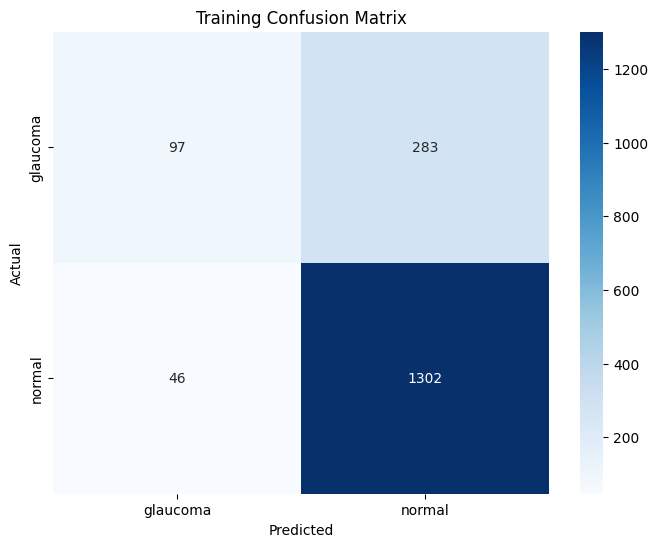

array([[  97,  283],
       [  46, 1302]])

time: 2min 40s (started: 2025-11-24 20:09:35 +00:00)


In [ ]:
plot_confusion_matrix(model, train_loader, class_names, title="Training Confusion Matrix")


Validation Confusion Matrix:
 [[ 10  73]
 [ 15 275]]


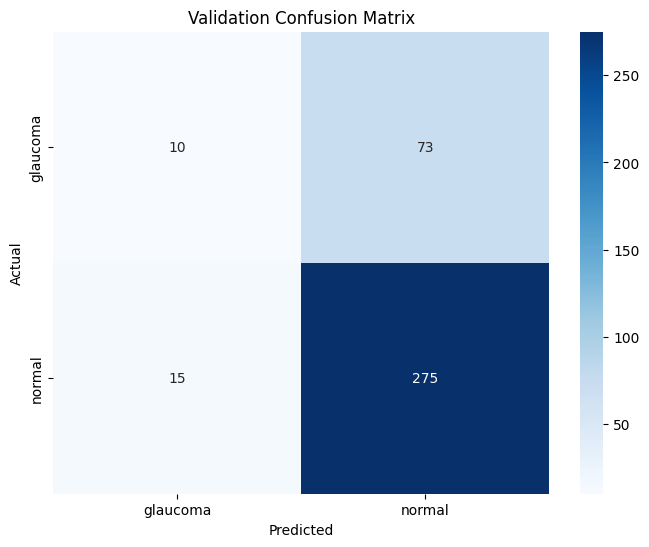

array([[ 10,  73],
       [ 15, 275]])

time: 37.8 s (started: 2025-11-24 20:13:00 +00:00)


In [ ]:
plot_confusion_matrix(model, valid_loader, class_names, title="Validation Confusion Matrix")


Test Confusion Matrix:
 [[  9  72]
 [ 22 267]]


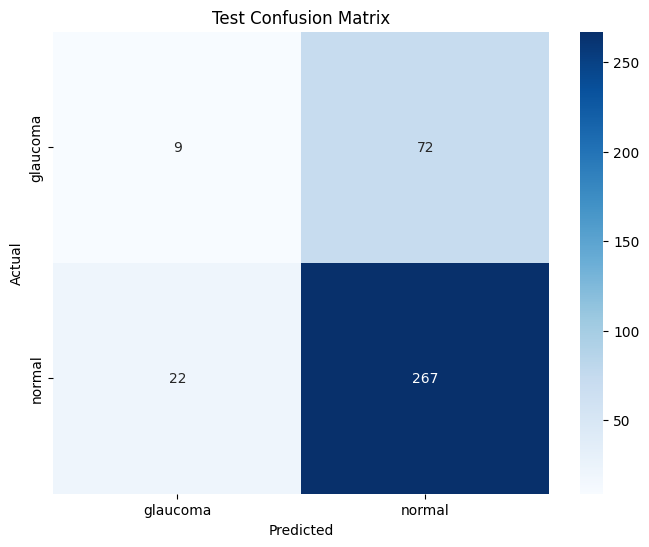

array([[  9,  72],
       [ 22, 267]])

time: 34.1 s (started: 2025-11-24 20:13:47 +00:00)


In [ ]:
plot_confusion_matrix(model, test_loader, class_names, title="Test Confusion Matrix")

In [ ]:
def plot_roc_curve(model, test_loader, class_names):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            probs = torch.softmax(outputs, dim=1)  # convert logits → probabilities

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())   # shape (batch,2)

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # ---- Manual 2-column binarize ----
    y_true_bin = np.zeros((len(y_true), len(class_names)))
    for idx, lab in enumerate(y_true):
        y_true_bin[idx, lab] = 1
    # ----------------------------------

    plt.figure(figsize=(10, 8))

    for i, name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)

        print(f"Class {name} ROC AUC: {roc_auc:.3f}")
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (DenseNet121)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

time: 3.65 ms (started: 2025-11-24 20:15:08 +00:00)


Class glaucoma ROC AUC: 0.672
Class normal ROC AUC: 0.672


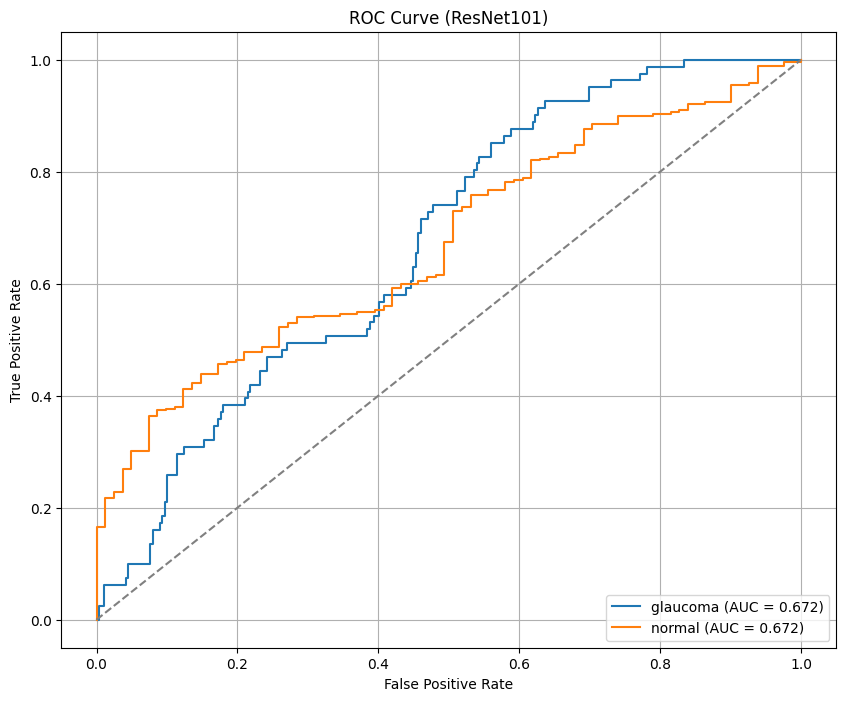

time: 38.8 s (started: 2025-11-24 20:15:29 +00:00)


In [ ]:
plot_roc_curve(model, test_loader, class_names)

Class glaucoma ROC AUC: 0.714
Class normal ROC AUC: 0.714


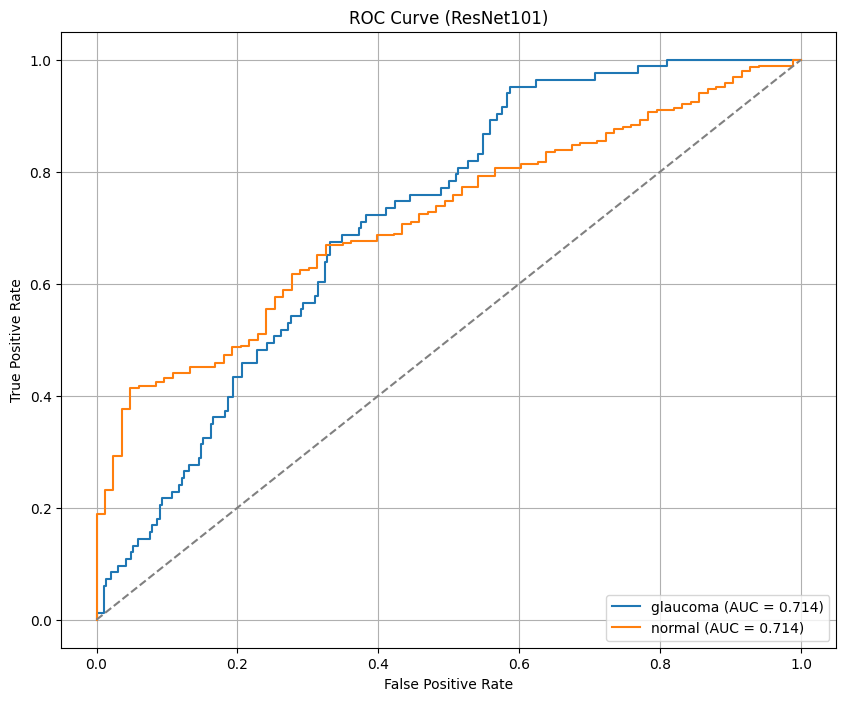

time: 34.2 s (started: 2025-11-24 20:16:13 +00:00)


In [ ]:
plot_roc_curve(model, valid_loader, class_names)

Class glaucoma ROC AUC: 0.830
Class normal ROC AUC: 0.830


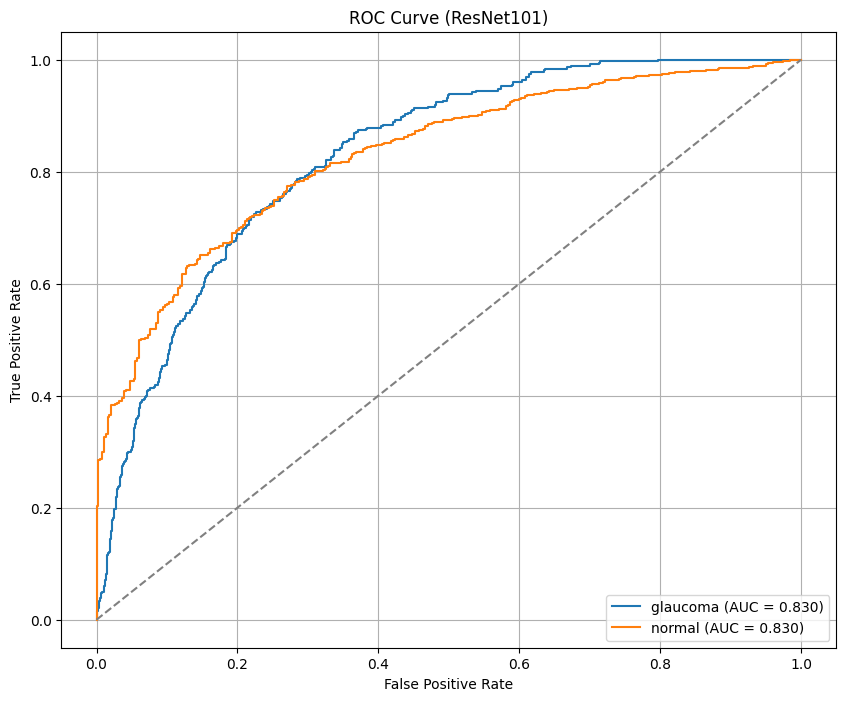

time: 2min 45s (started: 2025-11-24 20:16:52 +00:00)


In [ ]:
plot_roc_curve(model, train_loader, class_names)